# **Data load & preprocess**

The data was obtained from the following site: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

 There are two different typs of photos: "NORMAL" and "PNEUMONIA"

 "NORMAL", are the normal X-ray images of the chest without pneumonia
 
 "PNEUMONIA", are X-ray images of the chest with the pneumonia disease

### **_IMPORTS_**

In [37]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random

from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image

#### **_Checking label distribution_**

In [38]:
data_dir = "../data/chest_xray/"
sets = ['train', 'val', 'test']

for dataset in sets:
    normal_count = len(os.listdir(os.path.join(data_dir, dataset, "NORMAL")))
    pneumonia_count = len(os.listdir(os.path.join(data_dir, dataset, "PNEUMONIA")))
    
    print(f"\n📂 {dataset.upper()} SET")
    print(f"NORMAL: {normal_count} images")
    print(f"PNEUMONIA: {pneumonia_count} images")



📂 TRAIN SET
NORMAL: 3875 images
PNEUMONIA: 3875 images

📂 VAL SET
NORMAL: 8 images
PNEUMONIA: 8 images

📂 TEST SET
NORMAL: 234 images
PNEUMONIA: 390 images


Looks like the data is imbalanced, because there are more PNEUMONIA images then NORMAL images!

### **_Balance train_data_**

In [39]:
dir = "../data/chest_xray/train/NORMAL"

# # Data Augmentation Pipeline
# augment_transform = transforms.Compose([
#     transforms.RandomRotation(30),
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.RandomHorizontalFlip()#,
#     #transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.3)
# ])


augment_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)), 
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=10, shear=10),  # Neue Verzerrung hinzufügen
    transforms.GaussianBlur(3),  # Weiche Unschärfe hinzufügen
])


In [40]:
normal_images = os.listdir(dir)

# Saving of new changed data
for img_name in normal_images:
    if ("_aug" not in img_name):
        img_path = os.path.join(dir, img_name)
        image = Image.open(img_path).convert("RGB")

        for i in range(2):  # About 2 times each image should be used to get a similar number as pneumonia
            augmented_image = augment_transform(image)
            save_path = os.path.join(dir, f"{img_name.split('.')[0]}_aug{i}.jpg")
            augmented_image.save(save_path)

# random deletion of unnecessary images, so that the number of both is 3875
num_to_delete = 148
all_files = [file for file in os.listdir(dir) if "_aug" in file]  # new data
files_to_delete = random.sample(all_files, num_to_delete)

for file in files_to_delete:
    file_path = os.path.join(dir, file)
    os.remove(file_path)
    print(f"Deleted: {file_path}")

print(f"✅ {len(os.listdir(dir))} augmented NORMAL images created.")

Deleted: ../data/chest_xray/train/NORMAL\IM-0213-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0600-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-1295-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-1019-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0545-0001-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0557-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0872-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0468-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0867-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-1096-0001-0003_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0253-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0416-0001-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0425-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0880-0001_aug1.jpg
Deleted: ../data/chest_xray/tra

In [41]:
dataset = "train"

normal_count = len(os.listdir(os.path.join(data_dir, dataset, "NORMAL")))

pneumonia_count = len(os.listdir(os.path.join(data_dir, dataset, "PNEUMONIA")))

print(f"\n📂 {dataset.upper()} SET")
print(f"NORMAL: {normal_count} images")

print(f"PNEUMONIA: {pneumonia_count} images")



📂 TRAIN SET
NORMAL: 3875 images
PNEUMONIA: 3875 images


now the training data is balanced!

### **_GET DATA_**

### _Image pre-processing_

In [42]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # I would use the model "ResNet", which expects 224x224 images.
    transforms.ToTensor(), # the images are converted to Pytroch-tensor 
    transforms.Normalize([0.5], [0.5])  # normalisation
])

### _Load Datasets_


we now have to classify each picture whether it corresponds to "NORMAL" or "PNEUMONIA"

0 = "NORMAL", 1 = "PNEUMONIA"

In [43]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

In [44]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [45]:
print(train_dataset.class_to_idx)

{'NORMAL': 0, 'PNEUMONIA': 1}






### **_VISUALIZATIONS_**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


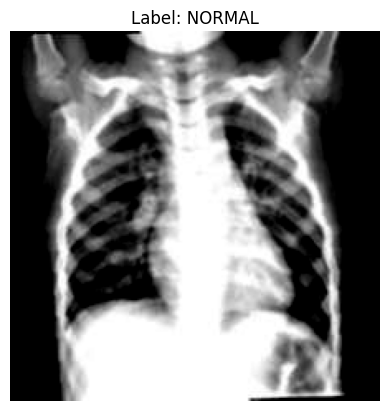

In [ ]:
# first picture in train_dataset
image, label = train_dataset[1] 

# Change order from (C, H, W) → (H, W, C) and convert to numpy array
image = image.permute(1, 2, 0).numpy()

# Display the image
plt.imshow(image)
plt.title("Label: NORMAL" if label == 0 else "Label: PNEUMONIA")
plt.axis('off')
plt.show()
